# House Prices: EDA to ML (Beginner)

## Part 0 : Imports, Settings, Functions

In [1]:
import numpy as np
import pandas as pd
#pd.set_option('max_columns', 105)
pd.options.display.max_rows = 105
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline 
sns.set()

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category =DeprecationWarning)
#warnings.filterwarnings("ignore")

# from subprocess import check_output
# print(check_output(['dir','D:/aiffel/kaggle_clone/data/house/']).decode('utf8'))



Settings and switches   

Here one can choose settings for optimal performance and runtime.   
For example, nr_cv sets the number of cross validations used in GridsearchCV, and   
min_val_corr is the minimum value for the correlation coefficient to the target (only features with larger correlation will be used).

In [60]:
# setting the number of cross validation used in the Model part
nr_cv = 5

# switch for using log values for SalePrice and features
use_logvals = 1
# target used for correlation
target='SalePrice_Log'

# only columns with correlation above this threshold value
# are used for the ML Regressors in Part 3
min_val_corr = 0.4

# switch for dropping columns that are similar to others already used and show a high correlation to these
drop_similar = 1

Some useful functions

In [3]:
def get_best_score(grid):
    best_score = np.sqrt(-grid. .best_score)
    print(best_score)
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [4]:
def print_cols_large_corr(df, nr_c, targ):
    corr = df.corr()
    corr_abs = corr.abs()
    print(corr_abs.nlargest(nr_c, targ)[targ])

In [76]:
def plot_corr_matrix(df, nr_c, targ):
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)
    
    plt.figure(figsize = (nr_c/1.5, nr_c/1.5))
    sns.set(font_scale = 1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

Load data

In [6]:
df_train = pd.read_csv('./data/house/train.csv')
df_test = pd.read_csv('./data/house/test.csv')

# Part 1: Exploratory Data Analysis

## 1.1 Overview of features and relation to target


### 1.1.0 description


Let's get a first overview of the train and test dataset   
How many rows and columns are there?   
What are the names of the features (columns)?   
Which features are numerical, which are categorical?   
How many values are missing?   
The __shape__ and __info__ methods answer these questions   
__head__ displays some rows of the dataset   
__describe__ gives a summary of the statistics (only for numerical columns)   

### 1.1.1 shape, info, head and describe

In [7]:
print(df_train.shape)
print('*'*50)
print(df_test.shape)

(1460, 81)
**************************************************
(1459, 80)


In [8]:
print(df_train.info())
print('*'*50)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

df train has 81 columns (79 features + id and target SalePrice) and 1460 entries (number of rows or house sales)   
df test has 80 columns (79 features + id) and 1459 entries   
There is lots of info that is probably related to the SalePrice like the area, the neighborhood, the condition and quality.   
Maybe other features are not so important for predicting the target,   
also there might be a strong correlation for some of the features    
(like GarageCars and GarageArea). For some columns many values are missing: only 7 values for Pool QC in df train and 3 in df test

In [14]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [12]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


### 1.1.2 columns


- SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
- MSSubClass: The building class
- MSZoning: The general zoning classification
- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- Street: Type of road access
- Alley: Type of alley access
- LotShape: General shape of property
- LandContour: Flatness of the property
- Utilities: Type of utilities available
- LotConfig: Lot configuration
- LandSlope: Slope of property
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to main road or railroad
- Condition2: Proximity to main road or railroad (if a second is present)
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- OverallQual: Overall material and finish quality
- OverallCond: Overall condition rating
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet
- ExterQual: Exterior material quality
- ExterCond: Present condition of the material on the exterior
- Foundation: Type of foundation
- BsmtQual: Height of the basement
- BsmtCond: General condition of the basement
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType1: Quality of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- Heating: Type of heating
- HeatingQC: Heating quality and condition
- CentralAir: Central air conditioning
- Electrical: Electrical system
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- GrLivArea: Above grade (ground) living area square feet
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Number of bedrooms above basement level
- Kitchen: Number of kitchens
- KitchenQual: Kitchen quality
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Functional: Home functionality rating
- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality
- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition
- PavedDrive: Paved driveway
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet
- PoolQC: Pool quality
- Fence: Fence quality
- MiscFeature: Miscellaneous feature not covered in other categories
- MiscVal: $Value of miscellaneous feature
- MoSold: Month Sold
- YrSold: Year Sold
- SaleType: Type of sale
- SaleCondition: Condition of sale

### 1.1.3 The target variable : Distribution of SalePrice

Skewness: 1.882876 
Kurtosis: 6.536282 


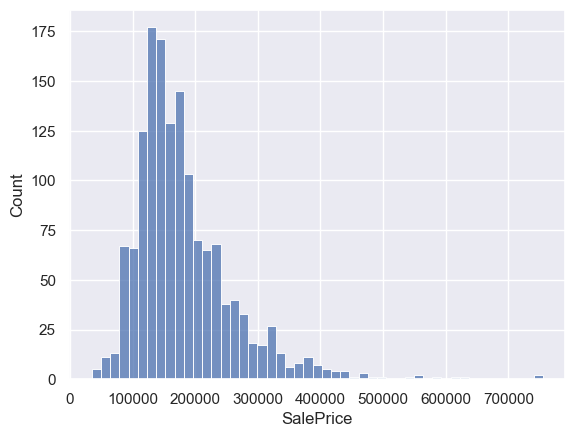

In [17]:
sns.histplot(df_train['SalePrice'])
#skewness and kurtosis
print("Skewness: %f "% df_train['SalePrice'].skew())
print("Kurtosis: %f "% df_train['SalePrice'].kurt())

As we see, the target variable SalePrice is not normally distributed.   
This can reduce the performance of the ML regression models because some assume normal distribution,   
see sklearn info on preprocessing   
Therfore we make a log transformation, the resulting distribution looks much better.

| 특징    | Skewness                                             | Kurtosis                                                                                    |
| ----- | ---------------------------------------------------- | ------------------------------------------------------------------------------------------- |
| 정의    | 확률 분포의 비대칭성을 측정하는 지표입니다.                            | 데이터가 정규 분포와 비교하여 꼬리가 두껍거나 얇은지를 측정하는 지표입니다.                                                  |
| 값의 범위 | \-0.5에서 0.5 사이는 대칭입니다.   <br> Skewness가 1이라는 것은 분포가 오른쪽으로 치우쳐져 있다는 것을 의미합니다. 즉, 분포의 꼬리가 왼쪽보다 오른쪽으로 길어졌다는 것을 나타냅니다                            | 정규 분포의 첨도는 3입니다. 첨도가 3보다 작으면 평평한 분포   (platykurtic)라고 하며,<br> 3보다 큰 경우는 뾰족한 분포(leptokurtic)라고 합니다. |
| 계산 방법 | Seaborn 라이브러리의 skew() 함수를 사용하여 Skewness를 계산 | Seaborn 라이브러리의 kurt() 함수를 사용하여 Kurtosis를 계산                                        |

Skewness: 1.882876 
Kurtosis: 6.536282 


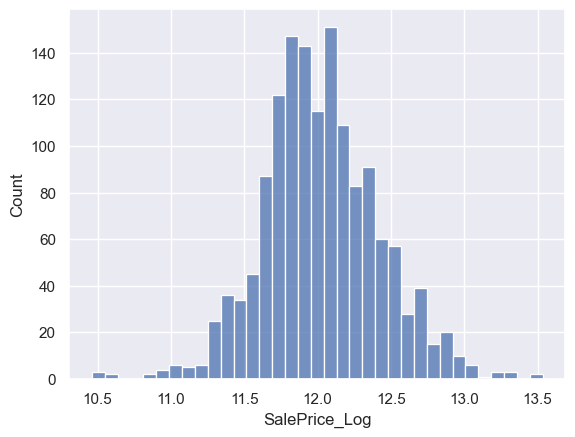

In [18]:
df_train['SalePrice_Log'] = np.log(df_train['SalePrice'])
sns.histplot(df_train['SalePrice_Log'])
#skewness and kurtosis
print("Skewness: %f "% df_train['SalePrice'].skew())
print("Kurtosis: %f "% df_train['SalePrice'].kurt())
#dripping old column
df_train.drop('SalePrice', axis = 1, inplace = True)


### 1.1.4 Numerical and Categorical features

In [19]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print('Number of Numberical features : ', len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print('Number of categorical features : ', len(categorical_feats))

Number of Numberical features :  38
Number of categorical features :  43


In [22]:
print(df_train[numerical_feats].columns)
print('*'* 100)
print(df_train[categorical_feats].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice_Log'],
      dtype='object')
****************************************************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Founda

In [23]:
df_train[numerical_feats].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice_Log
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,12.247694
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,12.109011
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,12.317167
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,11.849398
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,12.429216


In [24]:
df_train[categorical_feats].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### 1.1.5List of features with missing values

In [26]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


### 1.1.6 Filling missing values

For a few columns there is lots of NaN entries.   
However, reading the data description we find this is not missing data:   
For PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.

In [30]:
#columns where NaN values have meaning e.g. no pool etc
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
                'GarageQual','GarageCond','GarageFinish','GarageType','Electrical',
                'KitchenQual','SaleType','Functional','Exterior2nd','Exterior1st',
                'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1',
                'BsmtFinType2','MSZoning','Utilities']
#replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_train[col].fillna('None', inplace=True)
    df_test[col].fillna('None', inplace=True)

In [31]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
Id,0,0.000000
KitchenAbvGr,0,0.000000


In [32]:

#fillna with mean for the remaining columns: LotFrontae, GarageYrBlt, MasVnrArea
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)


In [33]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Id,0,0.0
CentralAir,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0


In [35]:
df_train.isnull().sum().sum()

0

In [36]:
df_test.isnull().sum().sum()

0

### 1.1.7 log transformation


Like the target variable, also some of the feature values are not normally distributed and    
it is therefore better to use log values in df_train and df_test. Checking for skewness and kurtosis:

In [37]:
for col in numerical_feats:
    print('{:15}'.format(col),
        'Skewness: {:05.2f}'.format(df_train[col].skew()),
        '  ',
        'Kurtosis: {:06.2f}'.format(df_train[col].kurt())
        )
    

Id              Skewness: 00.00    Kurtosis: -01.20
MSSubClass      Skewness: 01.41    Kurtosis: 001.58
LotFrontage     Skewness: 02.38    Kurtosis: 021.85
LotArea         Skewness: 12.21    Kurtosis: 203.24
OverallQual     Skewness: 00.22    Kurtosis: 000.10
OverallCond     Skewness: 00.69    Kurtosis: 001.11
YearBuilt       Skewness: -0.61    Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50    Kurtosis: -01.27
MasVnrArea      Skewness: 02.68    Kurtosis: 010.15
BsmtFinSF1      Skewness: 01.69    Kurtosis: 011.12
BsmtFinSF2      Skewness: 04.26    Kurtosis: 020.11
BsmtUnfSF       Skewness: 00.92    Kurtosis: 000.47
TotalBsmtSF     Skewness: 01.52    Kurtosis: 013.25
1stFlrSF        Skewness: 01.38    Kurtosis: 005.75
2ndFlrSF        Skewness: 00.81    Kurtosis: -00.55
LowQualFinSF    Skewness: 09.01    Kurtosis: 083.23
GrLivArea       Skewness: 01.37    Kurtosis: 004.90
BsmtFullBath    Skewness: 00.60    Kurtosis: -00.84
BsmtHalfBath    Skewness: 04.10    Kurtosis: 016.40
FullBath    

Skewness : 1.366560
Kurtosis : 4.895121


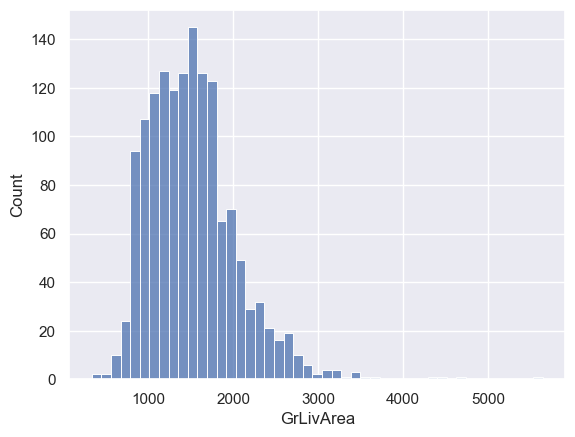

In [40]:
sns.histplot(df_train['GrLivArea'])
#skewness and kurtosis
print("Skewness : %f"% df_train['GrLivArea'].skew())
print("Kurtosis : %f"% df_train['GrLivArea'].kurt())

Skewness : 12.207688
Kurtosis : 203.243271


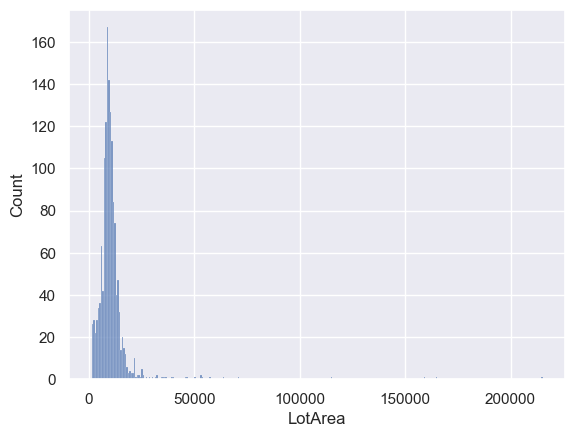

In [41]:
sns.histplot(df_train['LotArea'])
#skewness and kurtosis
print("Skewness : %f"% df_train['LotArea'].skew())
print("Kurtosis : %f"% df_train['LotArea'].kurt())

In [ ]:
for df in [df_train, df_test]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace=True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace=True, axis = 1)
    
numerical_feats = df_train.dtypes[df_train.dtypes !='object'].index

In [45]:
numerical_feats = df_train.dtypes[df_train.dtypes !='object'].index

Skewness : -0.006995
Kurtosis : 0.282603


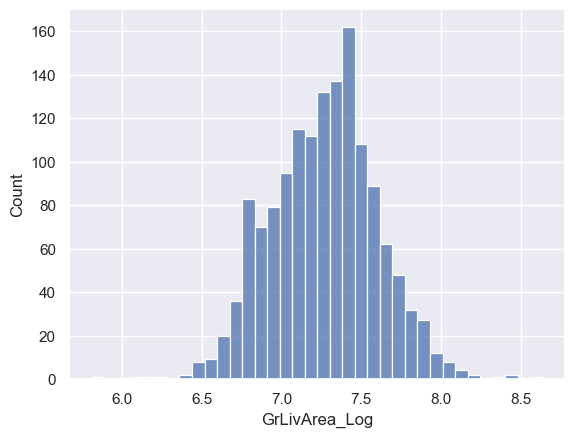

In [47]:
sns.histplot(df_train['GrLivArea_Log'])
#skewness and kurtosis
print("Skewness : %f"% df_train['GrLivArea_Log'].skew())
print("Kurtosis : %f"% df_train['GrLivArea_Log'].kurt())

Skewness : -0.137994
Kurtosis : 4.713358


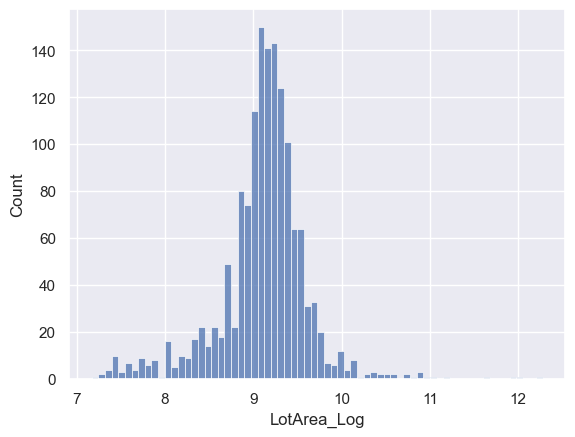

In [48]:
sns.histplot(df_train['LotArea_Log'])
#skewness and kurtosis
print("Skewness : %f"% df_train['LotArea_Log'].skew())
print("Kurtosis : %f"% df_train['LotArea_Log'].kurt())

## 1.2Relation of features to target (SalePrice_log)

### 1-2-1 Plots of relation to target for all numerical features

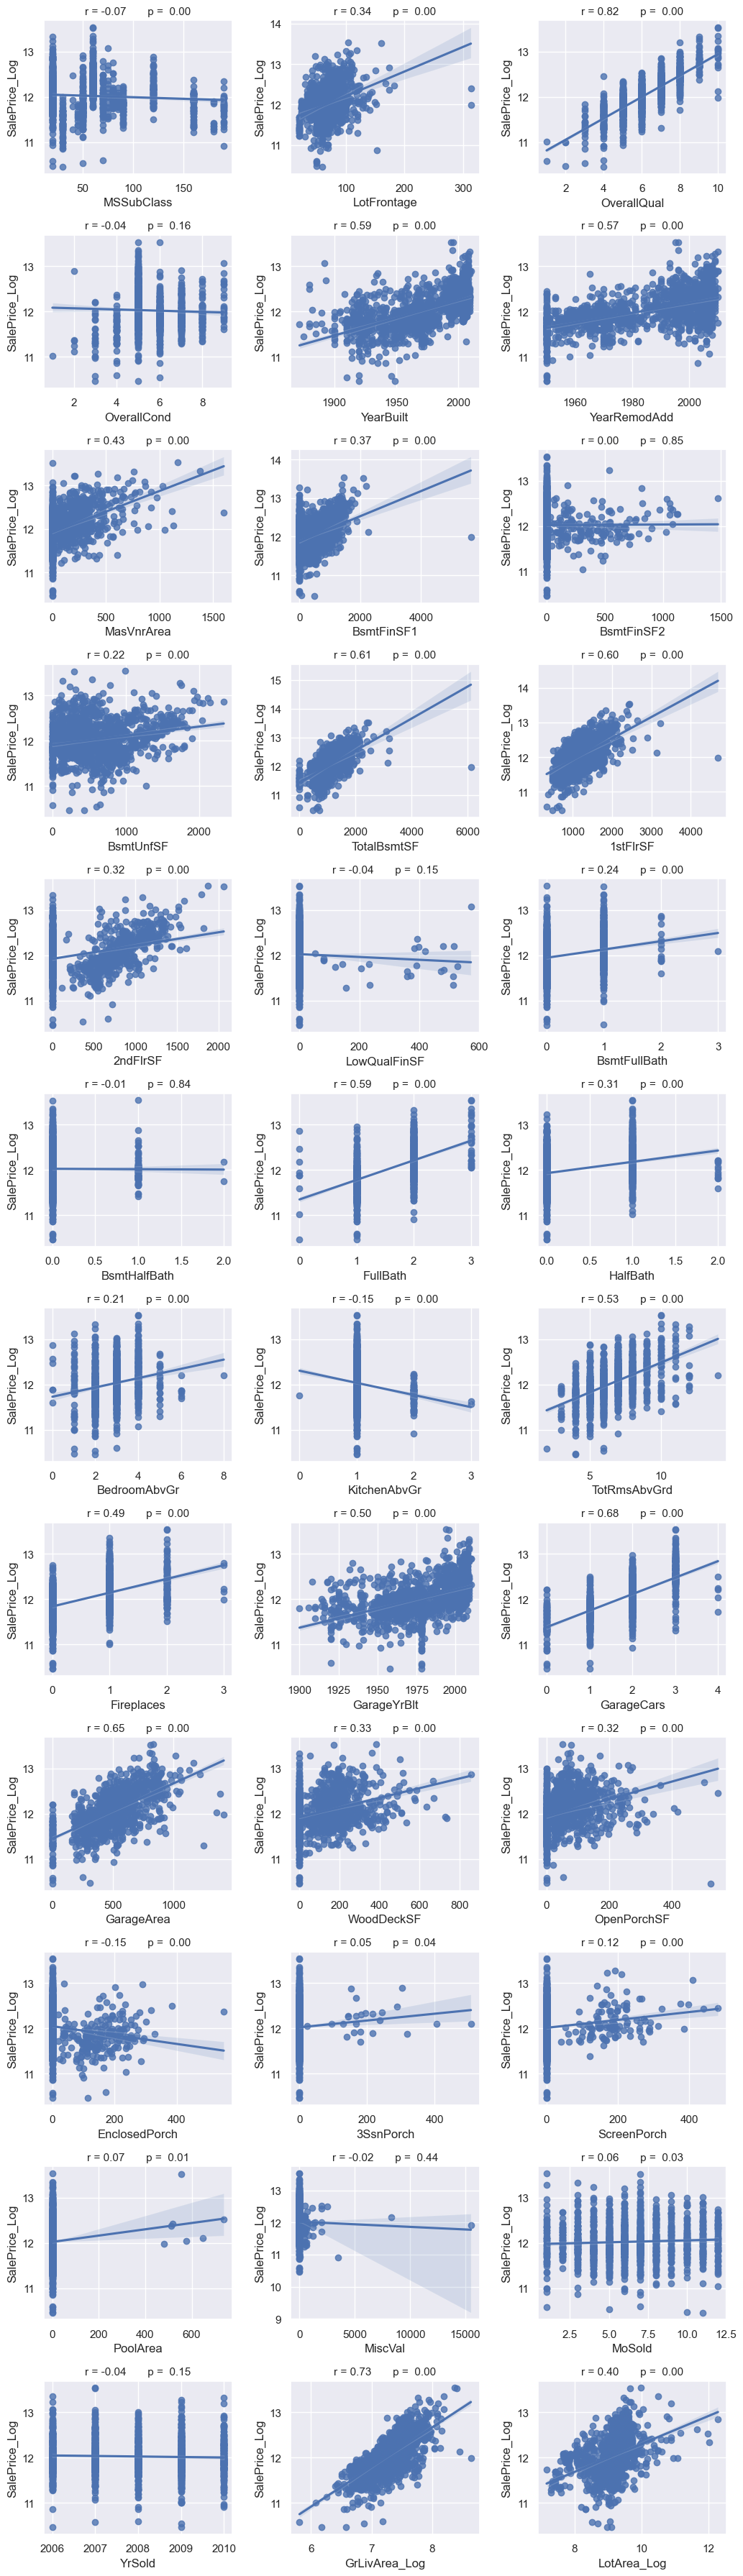

In [56]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5, nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r * nr_cols + c
        if i < len(li_plot_num_feats):
            sns.regplot(x=df_train[li_plot_num_feats[i]], y=df_train[target], ax=axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4, 0.9, 'title', fontsize=7)
            str_title = 'r = ' + '{0:.2f}'.format(stp[0]) +'       p =  ' + '{0:.2f}'.format(stp[1])
            axs[r][c].set_title(str_title, fontsize=11)
plt.tight_layout()
plt.show()

Conclusion from EDA on numerical columns:
We see that for some features like 'OverallQual' there is a strong linear correlation (0.79) to the target.   
For other features like 'MSSubClass' the correlation is very weak.   
For this kernel I decided to use only those features for prediction that have a correlation larger than a threshold value to SalePrice.   
This threshold value can be choosen in the global settings : min_val_corr   

With the default threshold for min_val_corr = 0.4, these features are dropped in Part 2, Data Wrangling:   
'Id', 'MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'

We also see that the entries for some of the numerical columns are in fact categorical values.   
For example, the numbers for 'OverallQual' and 'MSSubClass' represent a certain group for that feature ( see data description txt)   

Outliers

In [57]:
df_train = df_train.drop(
    df_train[(df_train['OverallQual'] ==10) & (df_train['SalePrice_Log'] <12.3)].index
    )

In [58]:
df_train = df_train.drop(
    df_train[(df_train['GrLivArea_Log'] ==10) & (df_train['SalePrice_Log'] <12.3)].index
    )

__Find columns with strong correlation to target___   
Only those with r > min_val_corr are used in the ML Regressors in Part 3    
The value for min_val_corr can be chosen in global settings   

In [69]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

List of numerical features and their correlation coefficient to target

In [62]:
print(ser_corr)
print('*'*30)
print('List of numerical features with r above min_val_corr :')
print(cols_abv_corr_limit)
print('*'*30)
print('List of numerical features with r below min_val_corr :')
print(cols_bel_corr_limit)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
GarageCars       0.681033
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
LotArea_Log      0.402814
BsmtFinSF1       0.392283
LotFrontage      0.352432
WoodDeckSF       0.334250
OpenPorchSF      0.325215
2ndFlrSF         0.319953
HalfBath         0.314186
BsmtFullBath     0.237099
BsmtUnfSF        0.221892
BedroomAbvGr     0.209036
EnclosedPorch    0.149029
KitchenAbvGr     0.147534
ScreenPorch      0.121245
PoolArea         0.074338
MSSubClass       0.073969
MoSold           0.057064
3SsnPorch        0.054914
LowQualFinSF     0.037951
YrSold           0.037151
OverallCond      0.036821
MiscVal          0.020012
Id               0.017774
BsmtHalfBath     0.005124
BsmtFinSF2       0.004863
Name: SalePr

List of categorical features and their unique values¶

In [70]:
for catg in list(categorical_feats):
    print(df_train[catg].value_counts())
    print('#'*50)

RL         1149
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1452
Grvl       6
Name: Street, dtype: int64
##################################################
None    1367
Grvl      50
Pave      41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    483
IR2     41
IR3      9
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      61
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1051
Corner      262
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1380
Mod      65
Sev      13
Name: LandSlope, dtype: int64
###########################

Relation to SalePrice for all categorical features

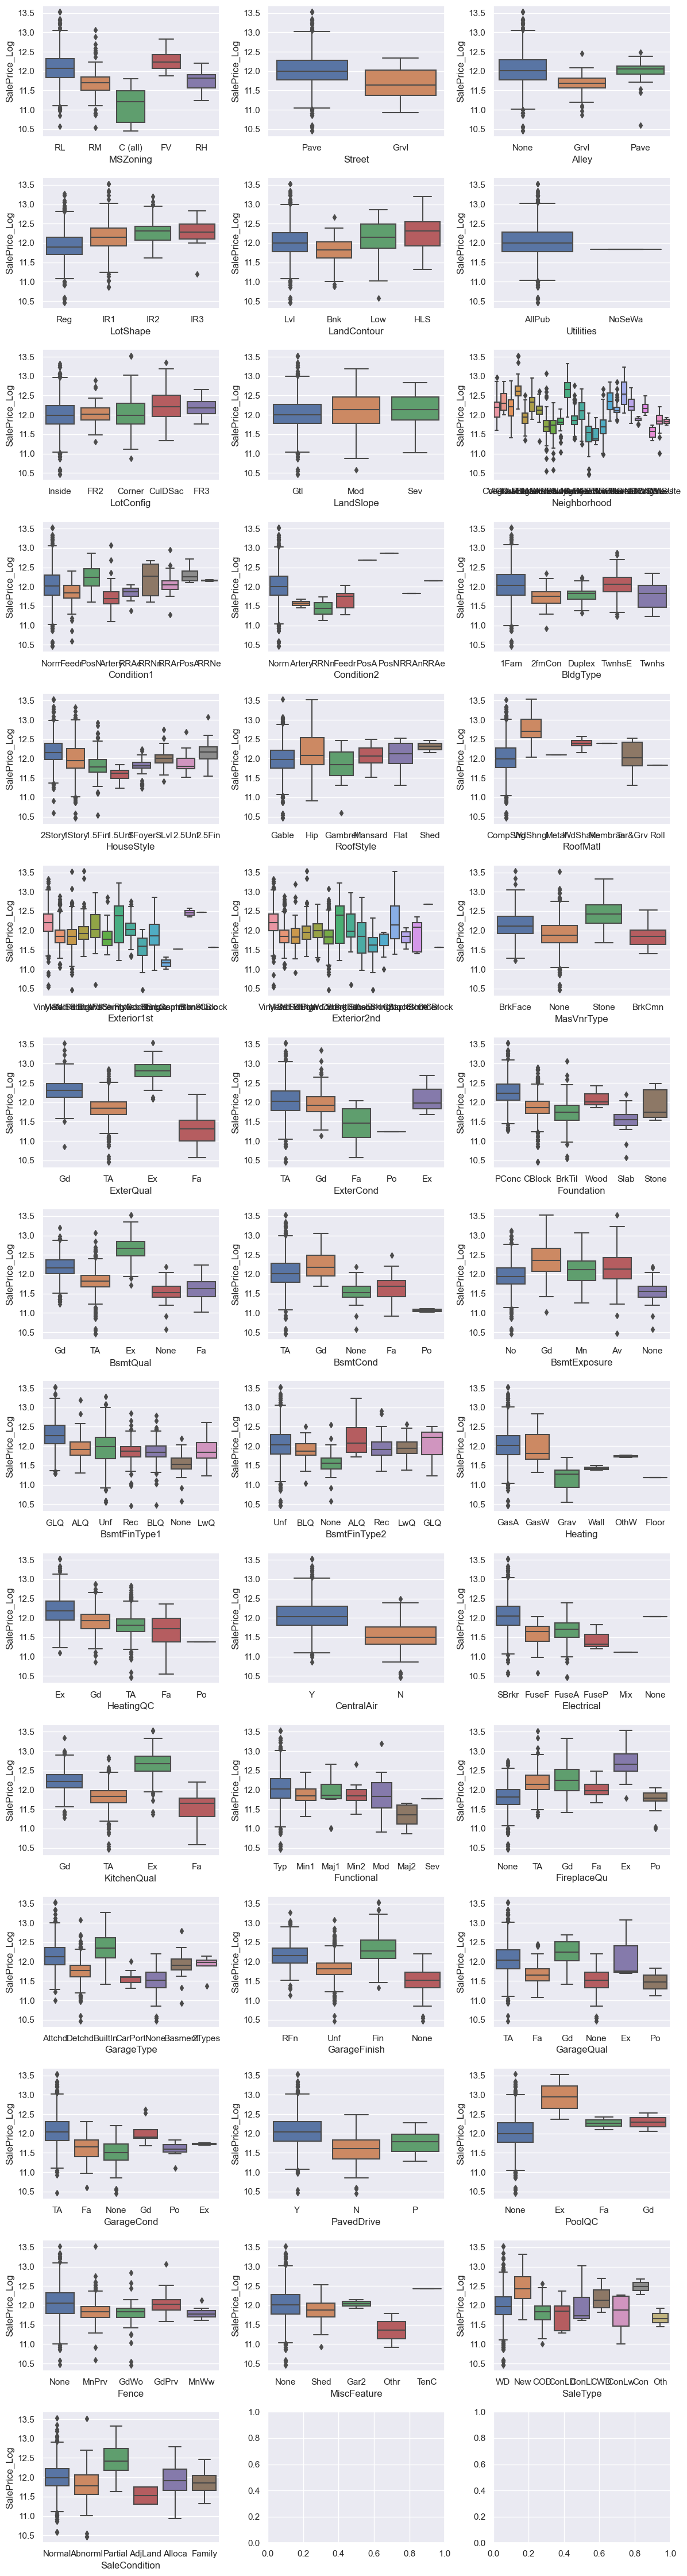

In [72]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols , figsize = (nr_cols * 4, nr_rows * 3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r * nr_cols + c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data = df_train, ax = axs[r][c])
            
plt.tight_layout()
plt.show()

Conclusion from EDA on categorical columns:   

For many of the categorical there is no strong relation to the target.
However, for some fetaures it is easy to find a strong relation.
From the figures above these are : `'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType'` Also for the categorical features, I use only those that show a strong relation to SalePrice. So the other columns are dropped when creating the ML dataframes in Part 2 :
'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleCondition'



In [73]:
catg_strong_corr= ['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual',
                    'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                    'LandSlope', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
                    'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation',
                    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                    'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
                    'SaleCondition']

Correlation matrix 1

__Features with largest correlation to SalePrice_Log__   
all numerical features with correlation coefficient above threshold

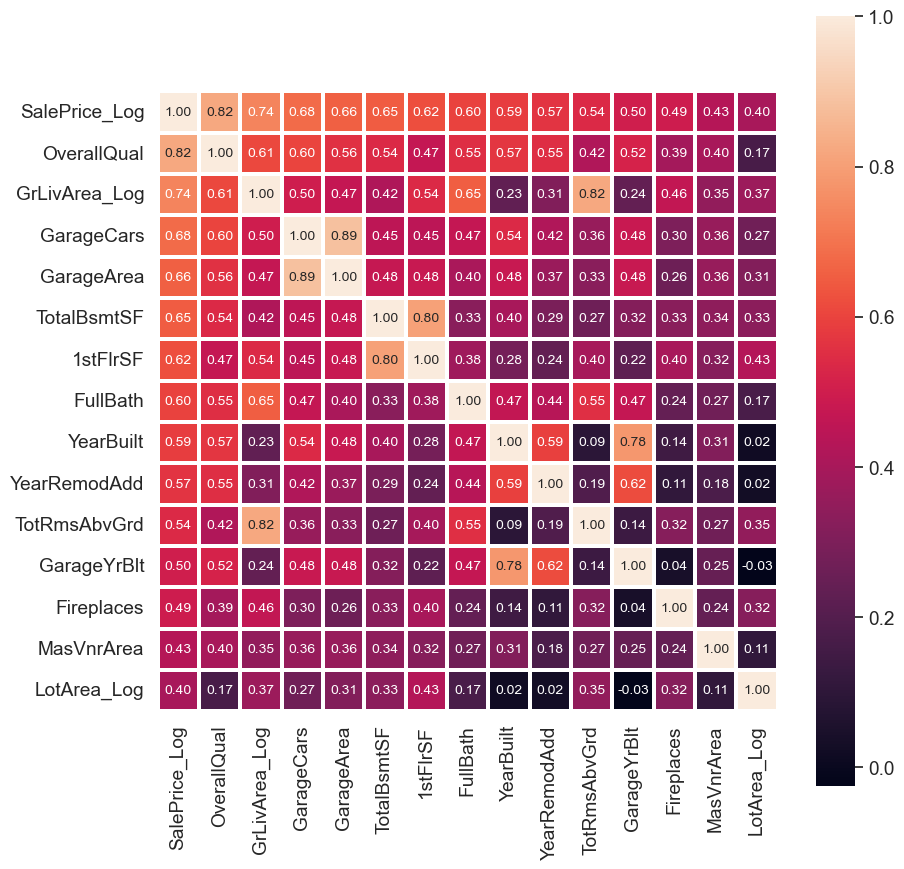

In [77]:
plot_corr_matrix(df_train, nr_feats, target)

Of those features with the largest correlation to SalePrice, some also are correlated strongly to each other.   
To avoid failures of the ML regression models due to multicollinearity, these are dropped in part 2.   
This is optional and controlled by the switch drop_similar (global settings)

# Part 2: Data wrangling

__Drop all columns with only small correlation to SalePrice   
Transform Categorical to numerical   
Handling columns with missing data   
Log values   
Drop all columns with strong correlation to similar features__

Numerical columns : drop similar and low correlation   
Categorical columns : Transform to numerical

Dropping all columns with weak correlation to SalePrice

In [87]:
id_test = df_test['Id']

to_drop_num = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace=True, axis=1)

__Convert categorical columns to numerical__   
For those categorcial features where the EDA with boxplots seem to show a strong dependence of the SalePrice on the category,<br>   we  transform the columns to numerical. To investigate the relation of the categories to SalePrice in more detail, we make violinplots<br> for    these features Also, we look at the mean of SalePrice as function of category.

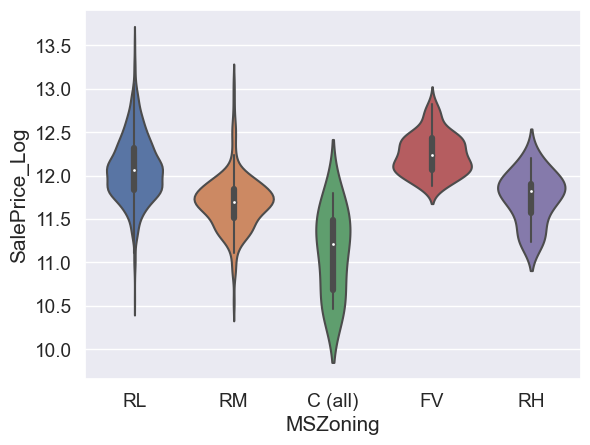

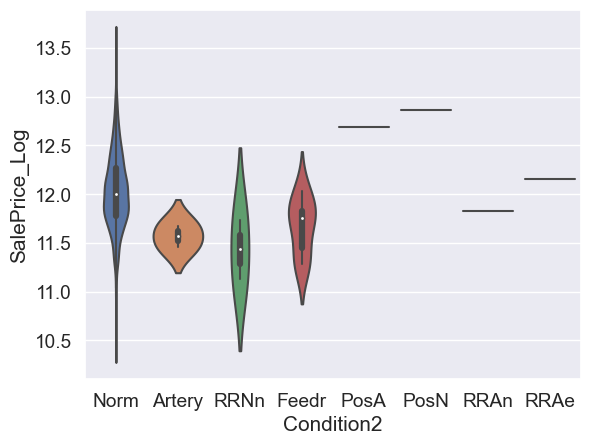

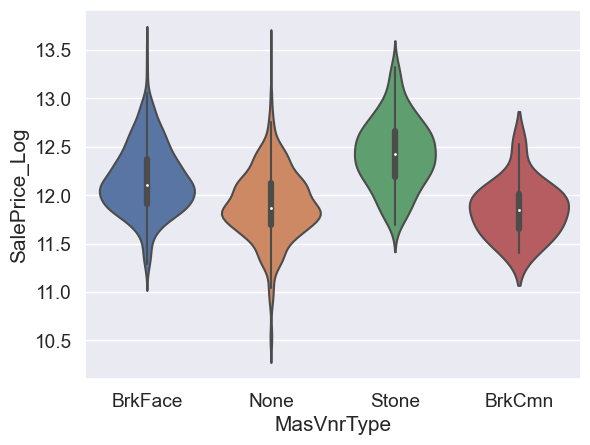

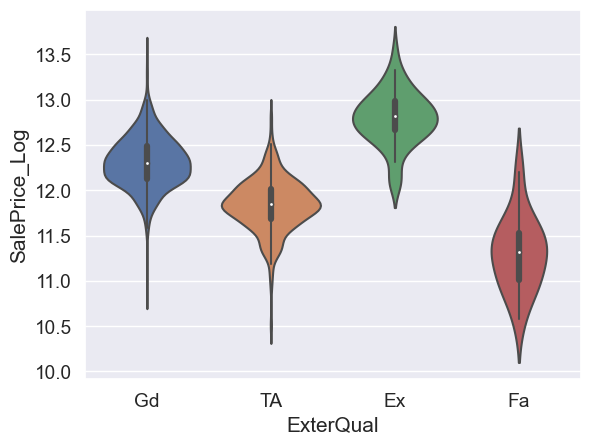

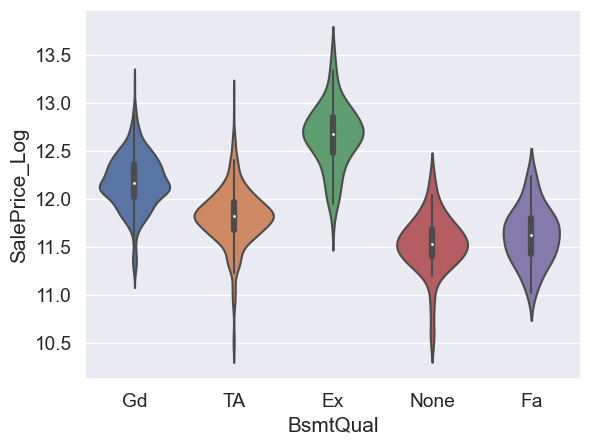

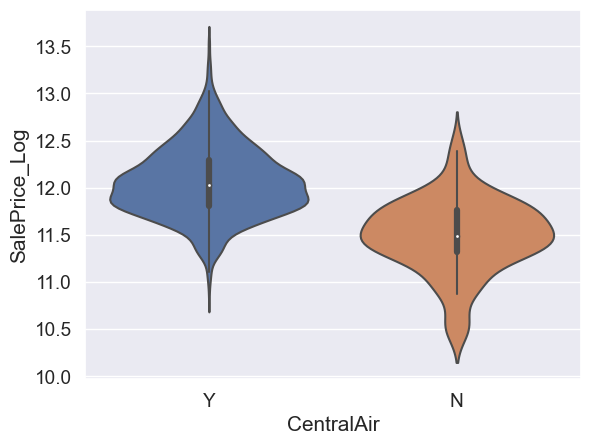

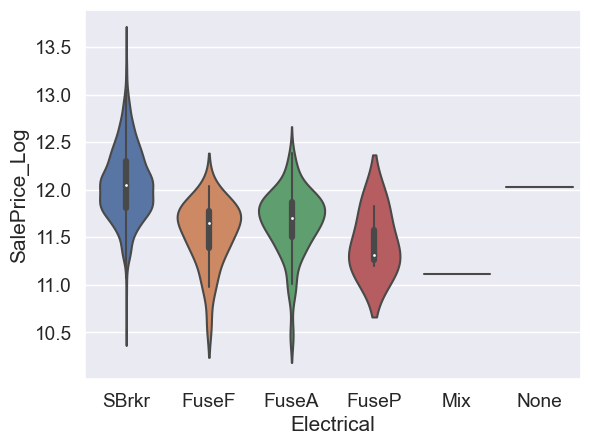

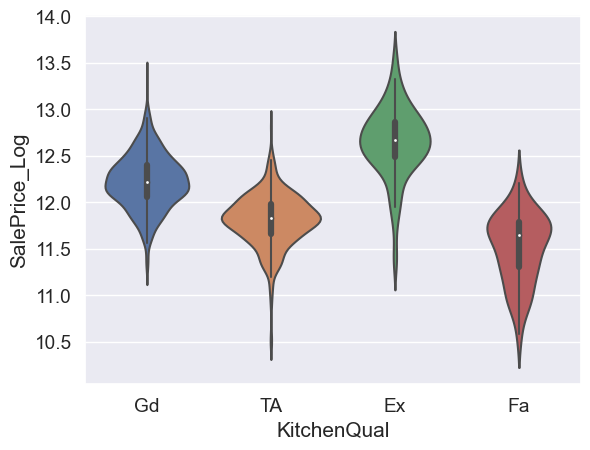

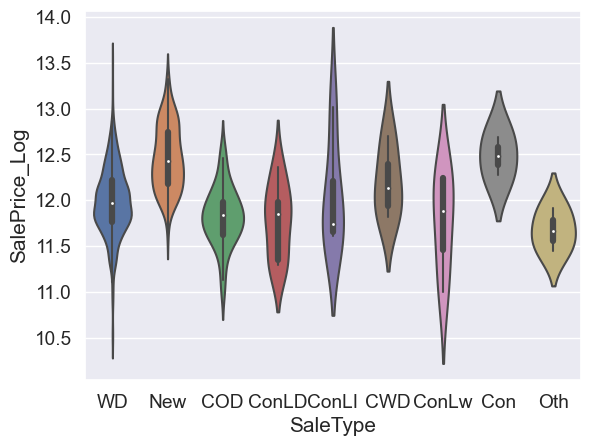

In [88]:
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

for catg in catg_list:
    #sns.catplot(x=catg, y=target, data=df_train, kind='boxen')
    sns.violinplot(x=catg, y=target, data=df_train)
    plt.show()
    #sns.boxenplot(x=catg, y=target, data=df_train)
    #bg = df_train.boxplot(column=[target], by=catg)

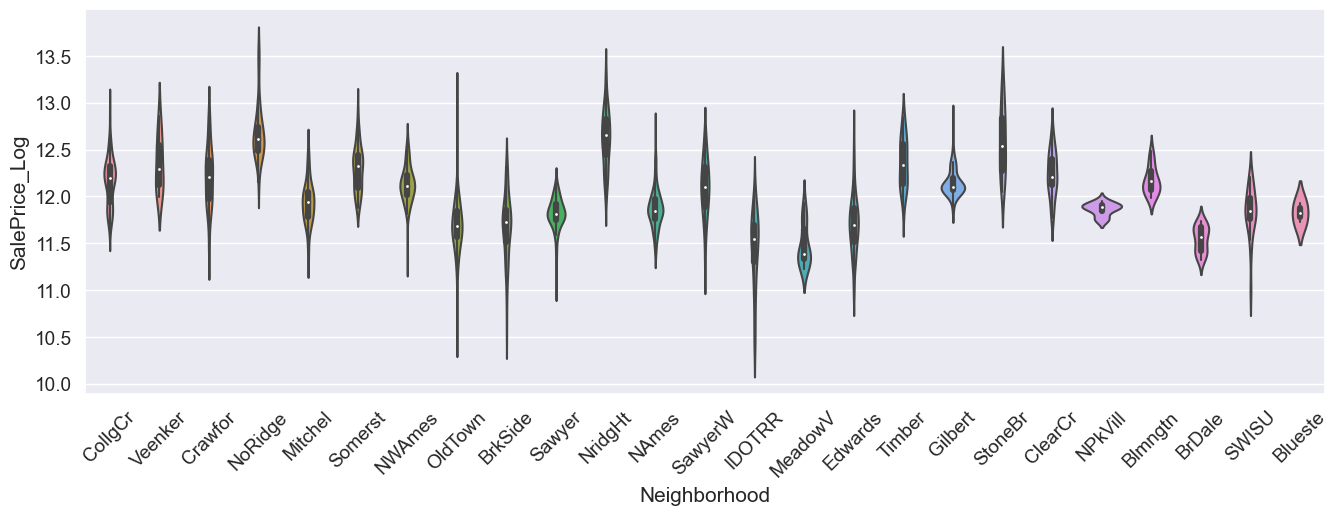

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(16,5)
sns.violinplot(x='Neighborhood', y = target, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [90]:
for catg in catg_list:
    g = df_train.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)    11.118259
FV         12.246616
RH         11.749840
RL         12.085939
RM         11.692893
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.670631
Norm      12.025925
PosA      12.691580
PosN      12.860999
RRAe      12.154779
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.853239
BrkFace    12.163630
None       11.896884
Stone      12.431016
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.792412
Fa    11.304541
Gd    12.311282
TA    11.837985
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.650235
Fa      11.617600
Gd      12.179882
None    11.529680
TA      11.810855
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.491858
Y    12.061099
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.660315
FuseF    11.539624
FuseP    11.446808
Mix      11.112448
None     12.028739
SBrkr    12.061474
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.645425
F

In [93]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH'] #11.5 이상 12미만
msz_catg3 = ['RL', 'FV'] #12이상


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker'] # 12~12.5
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']#12.5이상

# Condition2
cond2_catg2 = ['Norm', 'RRAe'] #12~12.5미만
cond2_catg3 = ['PosA', 'PosN'] #12.5이상

# SaleType
SlTy_catg1 = ['Oth'] #11.7미만
SlTy_catg3 = ['CWD'] #12이상 12.4미만
SlTy_catg4 = ['New', 'Con'] # 12.4이상


In [95]:
for df in [df_train, df_test]:
    
    df['MSZ_num'] = 1
    df.loc[(df['MSZoning'].isin(msz_catg2)), 'MSZ_num'] = 2
    df.loc[(df['MSZoning'].isin(msz_catg3)), 'MSZ_num'] = 3
    
    df['NbHd_num'] = 1
    df.loc[(df['Neighborhood'].isin(nbhd_catg2)), 'NbHd_num'] = 2
    df.loc[(df['Neighborhood'].isin(nbhd_catg3)), 'NbHd_num'] = 3
    
    df['Cond2_num'] = 1
    df.loc[(df['Condition2'].isin(cond2_catg2)), 'Cond2_num'] = 2
    df.loc[(df['Condition2'].isin(cond2_catg2)), 'Cond2_num'] = 3
    
    df['Mas_num'] = 1
    df.loc[(df['MasVnrType']=='Stone'), 'Mas_num'] = 2
    
    df['ExtQ_num'] = 1
    df.loc[(df['ExterQual']=='TA'), 'ExtQ_num'] = 2
    df.loc[(df['ExterQual']=='Gd'), 'ExtQ_num'] = 3
    df.loc[(df['ExterQual']=='Ex'), 'ExtQ_num'] = 4
    
    df['BsQ_num'] = 1
    df.loc[(df['BsmtQual']=='Gd'), 'BsQ_num'] = 2
    df.loc[(df['BsmtQual']=='Ex'), 'BsQ_num'] = 3

    df['CA_num'] = 0
    df.loc[(df['CentralAir']=='Y'), 'CA_num'] = 1

    df['Elc_num'] = 1
    df.loc[(df['Electrical']=='SBrkr'), 'Elc_num'] = 2
    
    df['KiQ_num'] = 1
    df.loc[(df['KitchenQual']=='TA'), 'KiQ_num'] = 2
    df.loc[(df['KitchenQual']=='Gd'), 'KiQ_num'] = 3
    df.loc[(df['KitchenQual']=='Ex'), 'KiQ_num'] = 4
    
    df['SlTy_num'] = 2
    df.loc[(df['SaleType'].isin(SlTy_catg1)), 'SlTy_num'] = 1
    df.loc[(df['SaleType'].isin(SlTy_catg3)), 'SlTy_num'] = 3
    df.loc[(df['SaleType'].isin(SlTy_catg4)), 'SlTy_num'] = 4
    


Checking correlation to SalePrice for the new numerical columns

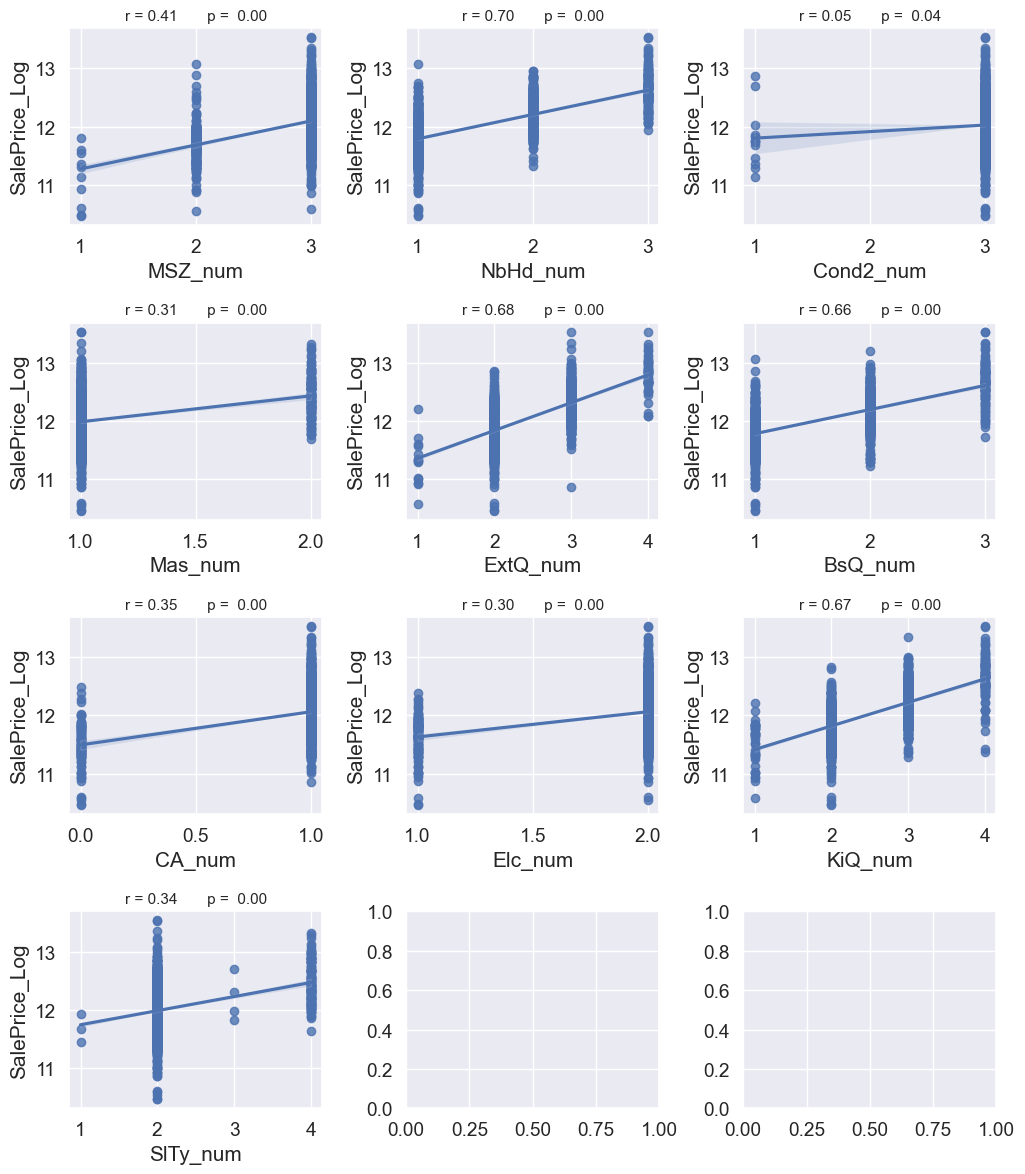

In [110]:
new_col_num =['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']

nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize =(nr_cols * 3.5, nr_rows * 3))

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r * nr_cols + c
        if i < len(new_col_num):
            sns.regplot(x= df_train[new_col_num[i]], y=df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target])
            str_title = 'r = ' + '{0:.2f}'.format(stp[0]) +'       p =  ' + '{0:.2f}'.format(stp[1])
            axs[r][c].set_title(str_title, fontsize=11)
plt.tight_layout()
plt.show()

There are few columns with quite large correlation to SalePrice (NbHd_num, ExtQ_num, BsQ_num, KiQ_num).   
These will probably be useful for optimal performance of the Regressors in part 3.

Dropping the converted categorical columns and the new numerical columns with weak correlation

columns and correlation before dropping

In [123]:
catg_cols_to_drop = ['Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical',
                    'KitchenQual', 'SaleType']

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)

for df in [df_train, df_test]:
    df.drop(catg_cols_to_drop, inplace = True, axis = 1)
    df.drop(cols_bel_corr_limit_1, inplace = True, axis=1)


SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
Name: SalePrice_Log, dtype: float64


KeyError: "['Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual', 'CentralAir', 'Electrical', 'KitchenQual', 'SaleType'] not found in axis"

columns and correlation after dropping

In [116]:
corr2=df_train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, target)[target]

print(ser_corr_2)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
HbHd_num         0.696962
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
Name: SalePrice_Log, dtype: float64


new dataframes

In [119]:
df_train.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,...,GarageCars,GarageArea,SalePrice_Log,GrLivArea_Log,LotArea_Log,MSZ_num,ExtQ_num,BsQ_num,KiQ_num,NbHd_num
0,RL,7,2003,2003,196.0,856,856,2,8,0,...,2,548,12.247694,7.444249,9.041922,3,3,2,3,2
1,RL,6,1976,1976,0.0,1262,1262,2,6,1,...,2,460,12.109011,7.140453,9.169518,3,2,2,2,2
2,RL,7,2001,2002,162.0,920,920,2,6,1,...,2,608,12.317167,7.487734,9.328123,3,3,2,3,2
3,RL,7,1915,1970,0.0,756,961,1,7,1,...,3,642,11.849398,7.448334,9.164296,3,2,1,3,2
4,RL,8,2000,2000,350.0,1145,1145,2,9,1,...,3,836,12.429216,7.695303,9.565214,3,3,2,3,3


In [124]:
df_test.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,...,LotArea_Log,MSZ_num,Cond2_num,Mas_num,ExtQ_num,BsQ_num,Elc_num,KiQ_num,SlTy_num,NbHd_num
0,RH,5,1961,1961,0.0,882.0,896,1,5,0,...,9.360655,2,3,1,2,1,2,2,2,1
1,RL,6,1958,1958,108.0,1329.0,1329,1,6,0,...,9.565704,3,3,1,2,1,2,3,2,1
2,RL,5,1997,1998,0.0,928.0,928,2,6,1,...,9.534595,3,3,1,2,2,2,2,2,1
3,RL,6,1998,1998,20.0,926.0,926,2,7,1,...,9.208138,3,3,1,2,1,2,3,2,1
4,RL,8,1992,1992,0.0,1280.0,1280,2,5,0,...,8.518193,3,3,1,3,2,2,3,2,1


__List of all features with strong correlation to SalePrice_Log__   
after dropping all coumns with weak correlation

In [125]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_all_cols = len(df_train)
print(corr_abs.nlargest(nr_all_cols, target)[target])

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
Name: SalePrice_Log, dtype: float64


Correlation Matrix 2 : All features with strong correlation to SalePrice

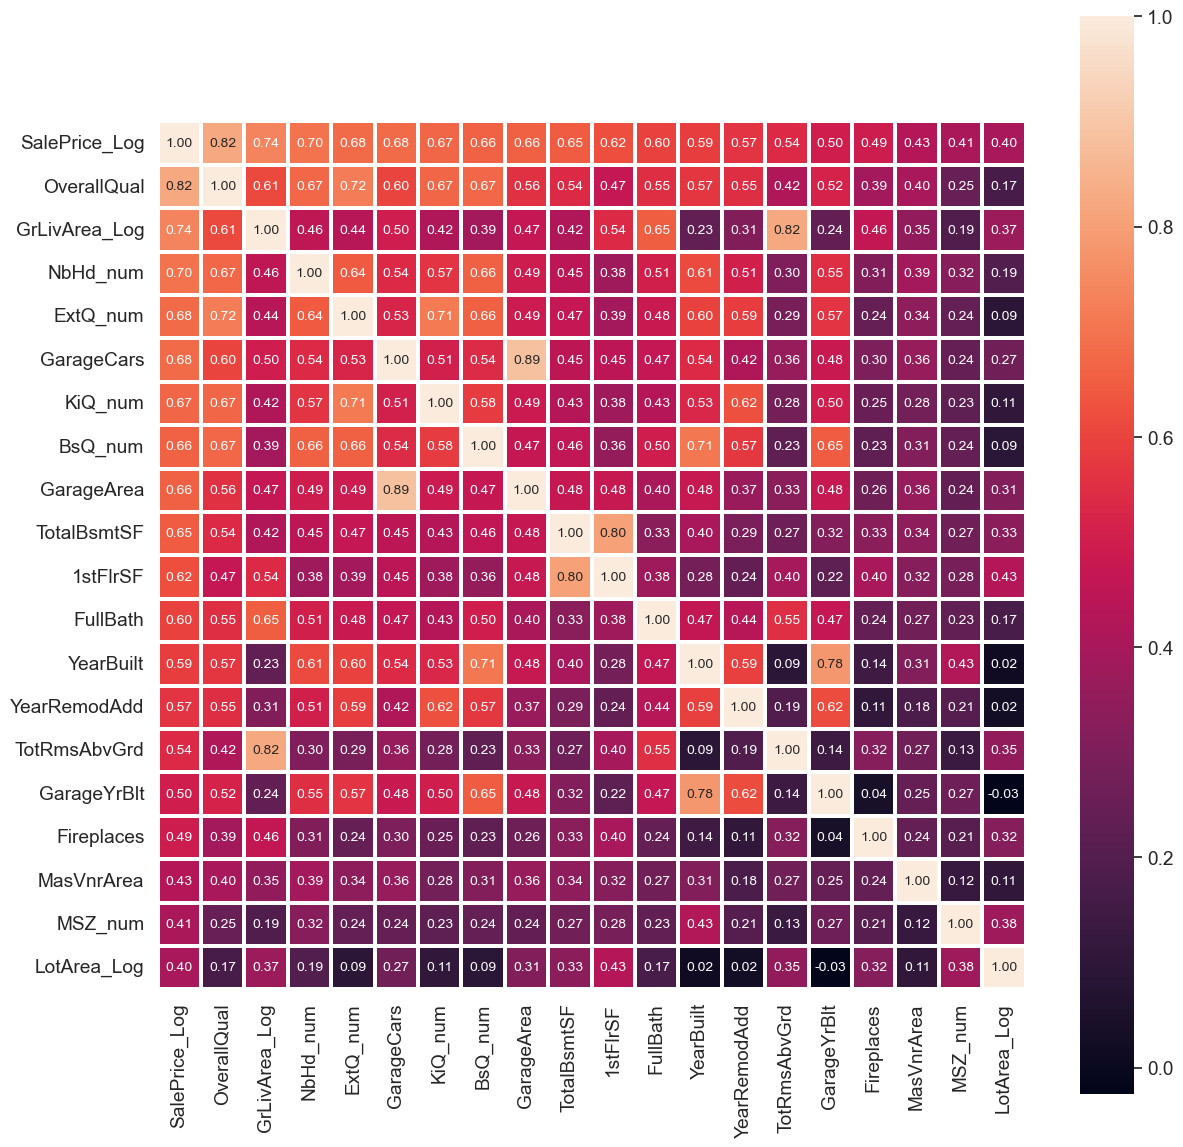

In [128]:
nr_feats = len(df_train.columns)
plot_corr_matrix(df_train, nr_feats, target)

__Check for Multicollinearity__   
Strong correlation of these features to other, similar features:   

'GrLivArea_Log' and 'TotRmsAbvGrd'   

'GarageCars' and 'GarageArea'   

'TotalBsmtSF' and '1stFlrSF'   

'YearBuilt' and 'GarageYrBlt'   

__Of those features we drop the one that has smaller correlation coeffiecient to Target.__



In [131]:
cols = corr_abs.nlargest(nr_all_cols,target)[target].index
cols = list(cols)

if drop_similar == 1:
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols:
            cols.remove(col)

In [132]:
cols = list(cols)
print(cols) # 16개

['SalePrice_Log', 'OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num', 'LotArea_Log']


List of features used for the Regressors in Part 3

In [134]:
feats = cols.copy()
feats.remove('SalePrice_Log')

print(feats)

['OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num', 'LotArea_Log']


In [135]:
df_train_ml = df_train[feats].copy()
df_test_ml = df_test[feats].copy()

y = df_train[target]

__Combine train and test data__   
for one hot encoding (use pandas get dummies) of all categorical features   
uncommenting the following cell increases the number of features   
up to now, all models in Part 3 are optimized for not applying one hot encoder   
when applied, GridSearchCV needs to be rerun

In [136]:
"""
all_data = pd.concat((df_train[feats], df_test[feats]))

li_get_dummies = ['OverallQual', 'NbHd_num', 'GarageCars','ExtQ_num', 'KiQ_num',
                'BsQ_num', 'FullBath', 'Fireplaces', 'MSZ_num']
all_data = pd.get_dummies(all_data, columns = li_get_dummies, drop_first=True)

df_train_ml = all_data[:df_train.shape[0]]
df_test_ml = all_data[df_train.shape[1]]
"""

"\nall_data = pd.concat((df_train[feats], df_test[feats]))\n\nli_get_dummies = ['OverallQual', 'NbHd_num', 'GarageCars','ExtQ_num', 'KiQ_num',\n                'BsQ_num', 'FullBath', 'Fireplaces', 'MSZ_num']\nall_data = pd.get_dummies(all_data, columns = li_get_dummies, drop_first=True)\n\ndf_train_ml = all_data[:df_train.shape[0]]\ndf_test_ml = all_data[df_train.shape[1]]\n"

StandardScaler

In [138]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [139]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.658506,0.539624,0.658963,1.061109,0.313159,0.741127,0.648281,-0.473766,0.793546,1.052959,0.880362,-0.952231,0.521228,0.438861,-0.129585
1,-0.068293,-0.380198,0.658963,-0.689001,0.313159,-0.770150,0.648281,0.504925,0.793546,0.158428,-0.428115,0.605965,-0.574433,0.438861,0.118848
2,0.658506,0.671287,0.658963,1.061109,0.313159,0.741127,0.648281,-0.319490,0.793546,0.986698,0.831900,0.605965,0.331164,0.438861,0.427653
3,0.658506,0.551993,0.658963,-0.689001,1.652119,0.741127,-0.921808,-0.714823,-1.025620,-1.862551,-0.718888,0.605965,-0.574433,0.438861,0.108680
4,1.385305,1.299759,2.162512,1.061109,1.652119,0.741127,0.648281,0.222888,0.793546,0.953567,0.734975,0.605965,1.382104,0.438861,0.889271


Creating Datasets for ML algorithms

In [141]:
X = df_train_ml.copy()
y = df_train[target]
X_test = df_test_ml.copy()

X_sc = df_train_ml_sc.copy()
y_sc = df_train[target]
X_test_sc = df_test_ml_sc.copy()

X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    1458 non-null   int64  
 1   GrLivArea_Log  1458 non-null   float64
 2   NbHd_num       1458 non-null   int64  
 3   ExtQ_num       1458 non-null   int64  
 4   GarageCars     1458 non-null   int64  
 5   KiQ_num        1458 non-null   int64  
 6   BsQ_num        1458 non-null   int64  
 7   TotalBsmtSF    1458 non-null   int64  
 8   FullBath       1458 non-null   int64  
 9   YearBuilt      1458 non-null   int64  
 10  YearRemodAdd   1458 non-null   int64  
 11  Fireplaces     1458 non-null   int64  
 12  MasVnrArea     1458 non-null   float64
 13  MSZ_num        1458 non-null   int64  
 14  LotArea_Log    1458 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 182.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (tota

In [142]:
X.head()

,OverallQual,GrLivArea_Log,NbHd_num,ExtQ_num,GarageCars,KiQ_num,BsQ_num,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Fireplaces,MasVnrArea,MSZ_num,LotArea_Log
0,7,7.444249,2,3,2,3,2,856,2,2003,2003,0,196.0,3,9.041922
1,6,7.140453,2,2,2,2,2,1262,2,1976,1976,1,0.0,3,9.169518
2,7,7.487734,2,3,2,3,2,920,2,2001,2002,1,162.0,3,9.328123
3,7,7.448334,2,2,3,3,1,756,1,1915,1970,1,0.0,3,9.164296
4,8,7.695303,3,3,3,3,2,1145,2,2000,2000,1,350.0,3,9.565214


In [143]:
X_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.658506,0.539624,0.658963,1.061109,0.313159,0.741127,0.648281,-0.473766,0.793546,1.052959,0.880362,-0.952231,0.521228,0.438861,-0.129585
1,-0.068293,-0.380198,0.658963,-0.689001,0.313159,-0.770150,0.648281,0.504925,0.793546,0.158428,-0.428115,0.605965,-0.574433,0.438861,0.118848
2,0.658506,0.671287,0.658963,1.061109,0.313159,0.741127,0.648281,-0.319490,0.793546,0.986698,0.831900,0.605965,0.331164,0.438861,0.427653
3,0.658506,0.551993,0.658963,-0.689001,1.652119,0.741127,-0.921808,-0.714823,-1.025620,-1.862551,-0.718888,0.605965,-0.574433,0.438861,0.108680
4,1.385305,1.299759,2.162512,1.061109,1.652119,0.741127,0.648281,0.222888,0.793546,0.953567,0.734975,0.605965,1.382104,0.438861,0.889271


In [144]:
X_test.head()

,OverallQual,GrLivArea_Log,NbHd_num,ExtQ_num,GarageCars,KiQ_num,BsQ_num,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Fireplaces,MasVnrArea,MSZ_num,LotArea_Log
0,5,6.797940,1,2,1.0,2,1,882.0,1,1961,1961,0,0.0,2,9.360655
1,6,7.192182,1,2,1.0,3,1,1329.0,1,1958,1958,0,108.0,3,9.565704
2,5,7.395722,1,2,2.0,2,2,928.0,2,1997,1998,1,0.0,3,9.534595
3,6,7.380256,1,2,2.0,3,1,926.0,2,1998,1998,1,20.0,3,9.208138
4,8,7.154615,1,3,2.0,3,2,1280.0,2,1992,1992,0,0.0,3,8.518193


# Part 3: Scikit-learn basic regression models and comparison of results

__Test simple sklearn models and compare by metrics__   

We test the following Regressors from scikit-learn:   
LinearRegression   
Ridge   
Lasso   
Elastic Net   
Stochastic Gradient Descent   
DecisionTreeRegressor   
RandomForestRegressor   
SVR   

 

__Model tuning and selection with GridSearchCV__  

In [145]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

Linear Regression

In [149]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True, False], 'copy_X':[True, False]} # , 'normalize':[True, False]
grid_linear = GridSearchCV(linreg, parameters , cv = nr_cv, verbose = 1, scoring= score_calc)
grid_linear.fit(X,y)

#sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

In [150]:
linreg_sc = LinearRegression()
parameters = {'fit_intercept':[True, False], 'copy_X':[True, False]} # , 'normalize':[True, False]
grid_linear_sc = GridSearchCV(linreg_sc, parameters , cv = nr_cv, verbose = 1, scoring= score_calc)
grid_linear_sc.fit(X_sc,y)

#sc_linear_sc = get_best_score(grid_linear_sc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

In [151]:
linregr_all = LinearRegression()
#ligregr_all.fit(X_train_all, y_train_all)
linregr_all.fit(X, y)
pred_linreg_all = linregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all<0] = pred_linreg_all.mean()

In [152]:
sub_linreg = pd.DataFrame()
sub_linreg['Id'] = id_test
sub_linreg['SalePrice'] = pred_linreg_all
#sub_linreg.to_csv('linreg.csv',index=False)

Ridge